In [1]:
import sys
import os
import gzip
from optparse import OptionParser
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import pearsonr, spearmanr, linregress
import plotly.express as px
import pyBigWig

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
def calculate_bw(bw, chr, start, end):
    try:
        return np.mean(bw.values(chr, start, end))
    except:
        return np.nan        

In [4]:
## Paths
figure_folder = "../figures/"

In [5]:
## Read GATA/non-GATA library file
eBC_file = pd.read_csv("total_library_final_with_BC.txt", sep="\t")
eBC_file_filtered = eBC_file[(eBC_file["group"] == "GATA1")|(eBC_file["group"] == "non_GATA1")].drop_duplicates(subset=["chr", "start", "end"]).reset_index(drop=True)

In [6]:
## Read GATA/non-GATA library file
eBC_file = pd.read_csv("total_library_final_with_BC.txt", sep="\t")
eBC_file_filtered = eBC_file[(eBC_file["group"] == "GATA1")|(eBC_file["group"] == "non_GATA1")].drop_duplicates(subset=["chr", "start", "end"]).reset_index(drop=True)

In [10]:
## Intersect the library with ENCODE-annotated promoter-like element using bedtools and then read the results
closest_P = pd.read_csv("total_library_final_with_BC_no_head_closest_P.txt", sep="\t", header=None)
closest_P = closest_P.drop_duplicates(subset=[0,1,2]).reset_index(drop=True)
eBC_file= pd.merge(eBC_file_filtered, closest_P[[0,1,2,10,11,12,21]], left_on=["chr", "start", "end"], right_on=[0,1,2], how="left")
eBC_file = eBC_file[["chr", "start", "end", "sequence", "name", "flag", "eBC", "length", "GC", "group", 10,11,12,21]]
eBC_file.columns = list(eBC_file.columns)[:-4]+["promoter_chr", "promoter_start", "promoter_end", "E-P Distance"]
eBC_file["E-P Distance"] = abs(eBC_file["E-P Distance"])

## Remove enhancers that overlap with promoters
eBC_file = eBC_file[eBC_file["E-P Distance"] != 0]

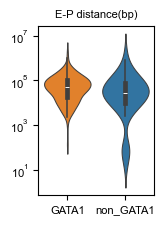

In [11]:
## Check E-P distance
plt.figure(figsize=(1.5,2.2))
sns.violinplot(data=eBC_file[eBC_file["E-P Distance"]!=0], x="group", y="E-P Distance", hue="group", hue_order=["non_GATA1", "GATA1"],log_scale=True, linewidth=0.75)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("E-P distance(bp)", fontsize=8)
plt.savefig(figure_folder+"GATA_lib_distance.svg", dpi=300)

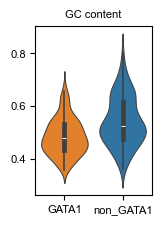

In [12]:
## Check GC content
plt.figure(figsize=(1.5,2.2))
sns.violinplot(data=eBC_file, x="group", y="GC", hue="group", hue_order=["non_GATA1", "GATA1"], linewidth=0.75)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("GC content", fontsize=8)
plt.savefig(figure_folder+"GATA_lib_GC.svg", dpi=300)

In [13]:
## Read lentiMPRA data for members in GATA1/non-GATA1 library
MPRA = pd.read_csv("/lts/bclab/Current2/yawei_new/yawei_scratch/240103_DLP1_S4_nextseq/MPRA_nadav/GATA_library_with_Nadav_MPRA.txt", sep="\t", header=None)
MPRA = pd.merge(MPRA, eBC_file, left_on=11, right_on="name")

In [14]:
## Read lentiMPRA data for all K562 enhancers
MPRA_all = pd.read_csv("/lts/bclab/Current2/yawei_new/yawei_scratch/240103_DLP1_S4_nextseq/MPRA_nadav/K562_MPRA_all_pos.txt", sep="\t")
MPRA_all["name"] = MPRA_all["chr"]+":"+MPRA_all["start"].astype(str)+"-"+MPRA_all["end"].astype(str)
MPRA_all.loc[MPRA_all["category"].str.contains("negative"),"group"] = "negative"
MPRA_all.loc[MPRA_all["category"].str.contains("positive"),"group"] = "MPRA_positive"
MPRA_all.loc[MPRA_all["category"].str.contains("enhancer"),"group"] = "MPRA_all"
MPRA_all = MPRA_all[["chr", "start", "end", "name", "mean", "group"]]
MPRA_all["overlap"] = 200
eBC_file_merged = pd.merge(eBC_file, MPRA_all[MPRA_all["group"] == "negative"][["chr", "start", "end", "group"]], how="outer")

In [15]:
MPRA = MPRA[[11,17,6, "group"]]
MPRA.columns = ["name", "overlap", "mean", "group"]
MPRA = pd.merge(MPRA, MPRA_all[MPRA_all["group"] == "negative"][["name", "overlap", "mean", "group"]], how="outer")
MPRA = MPRA[(MPRA["overlap"]>150)&(~MPRA["name"].str.contains("scramble"))].reset_index(drop=True)

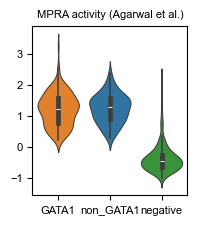

In [16]:
plt.figure(figsize=(2,2.2))
sns.violinplot(data=MPRA, x="group", y="mean",hue="group", hue_order=["non_GATA1", "GATA1", "negative"],linewidth=0.75)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("MPRA activity (Agarwal et al.)", fontsize=8)
plt.savefig(figure_folder+"GATA_lib_MPRA.svg", dpi=300)

In [19]:
## Calculate mean ChIP-seq signal of all enhancers in the library
tracks = ["H3K27ac", "H3K4me3", "POLR2A", "GATA1", "TAL1", "EP300", "ATF1", "CTCF"]
bw_path = "/ref/bclab/data/ENCODE/K562/"

for track in tracks:
    bw_file = pyBigWig.open(bw_path+track+".bigWig")
    eBC_file_merged[track] = eBC_file_merged.apply(lambda x:calculate_bw(bw_file, x["chr"], int(x["start"]), int(x["end"])), axis=1)

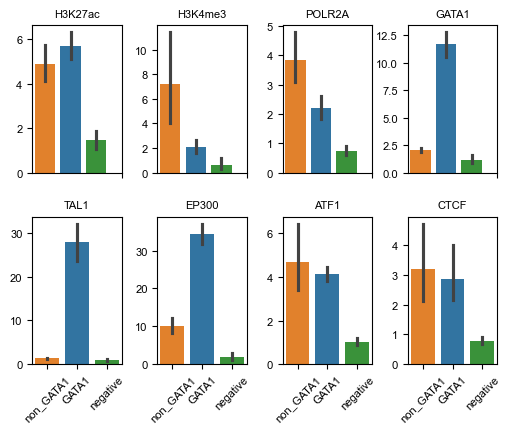

In [20]:
## Make barplots for all ChIP-seq tracks
chipseq_long = eBC_file_merged[["group", *tracks]].melt(id_vars="group", 
                                                        value_vars=tracks,
                                                        var_name='type', 
                                                        value_name='mean ChIP-seq signal')

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(6, 4.4))

for i, ax in zip(range(8), axes.flat):
    track = tracks[i]
    sns.barplot(eBC_file_merged, x="group", y=track, hue="group", hue_order=["GATA1", "non_GATA1", "negative"], ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="x", labelsize=8, rotation=45)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_title(track, fontsize=8)
    if i in [0,1,2,3]:
        ax.set_xticks("")
fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [21]:
## Standardize ChIP-seq signal for heatmap
chipseq_standard = eBC_file_merged[tracks]
chipseq_standard = (chipseq_standard - chipseq_standard.mean())/chipseq_standard.std()
chipseq_standard["group"] = eBC_file_merged["group"]
chipseq_standard_grouped = chipseq_standard.groupby("group").mean()
chipseq_standard_grouped = chipseq_standard_grouped.reindex(index = ["GATA1", "non_GATA1", "negative"])

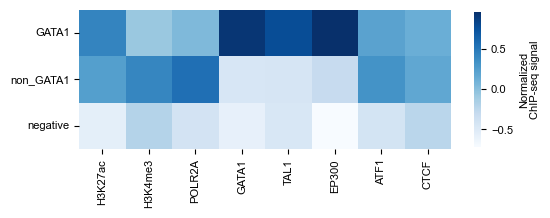

In [22]:
## Plot heatmap
plt.figure(figsize=(6,2.2))
ax = sns.heatmap(chipseq_standard_grouped, square=True, cmap="Blues", cbar_kws={"shrink": 0.8, "label": "Normalized\nChIP-seq signal"})
ax.collections[0].colorbar.ax.tick_params(labelsize=8)
ax.figure.axes[-1].yaxis.label.set_size(8)
plt.ylabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(figure_folder+"GATA_lib_ChIP_heatmap.svg", dpi=300)
